In [22]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
import joblib

In [23]:
# Load the dataset
df = pd.read_csv("../ALL_BUS/history_all.csv")

In [24]:
df = df[["travel_time","date","hour_of_day","start_terminal","weekend"]]

In [25]:
df['weekday'] = 1 - df['weekend']
df = df.drop(columns=['weekend'])

In [26]:
def calculate_rush_hour(row):
    if (0 <= row['hour_of_day'] <= 5) or (18 <= row['hour_of_day'] <= 23):
        return 0
    elif ((7 <= row['hour_of_day'] <= 8) and (row['start_terminal'] == 'Digana')):
        return 0
    elif (((7 <= row['hour_of_day'] <= 11) or (14 <= row['hour_of_day'] <= 17)) and (row['start_terminal'] == 'Kandy')):
        return 1
    elif (((6 == row['hour_of_day']) or (12 <= row['hour_of_day'] <= 13)) and (row['start_terminal'] == 'Kandy')):
        return 2
    elif ((row['hour_of_day'] == 13) and (row['start_terminal'] == 'Digana')):
        return 2
    elif (((6 == row['hour_of_day']) or (9 <= row['hour_of_day'] <= 12) or (14 <= row['hour_of_day'] <= 17)) and (row['start_terminal'] == 'Digana')):
        return 1
    else:
        return 0

# Apply the function to create the 'rush_hour' column
df['rush_hour'] = df.apply(calculate_rush_hour, axis=1)

In [31]:
df['hour_of_the_day'] = df['hour_of_day'].astype(int)
df = df.drop('hour_of_day', axis=1)

In [42]:
bus_running_time_df = pd.read_csv("../../Raw GPS data Kandy Buses/bus_running_times_feature_added_all.csv")
bus_running_time_df = bus_running_time_df[(bus_running_time_df["date"]>='2022-09-01') & (bus_running_time_df["date"]<='2022-10-30')]
bus_running_time_df["hour_of_day"] = bus_running_time_df["hour_of_day"].astype(int)
bus_running_time_df.head()

,trip_id,deviceid,direction,segment,date,start_time,end_time,run_time,run_time_in_seconds,length,...,rt(n-2),rt(n-3),hour_of_day,day,month,temp,precip,windspeed,conditions,dt(n-1)
148409,21727.0,1166.0,1.0,1.0,2022-09-01,06:31:21,06:33:21,0:02:00,120.0,0.63,...,113.0,113.0,6,1.0,9.0,19.7,0.0,4.0,Overcast,0.0
148410,21727.0,1166.0,1.0,2.0,2022-09-01,06:35:06,06:39:16,0:04:10,250.0,1.28,...,279.0,279.0,6,1.0,9.0,19.7,0.0,4.0,Overcast,105.0
148411,21727.0,1166.0,1.0,3.0,2022-09-01,06:40:31,06:50:01,0:09:30,570.0,2.11,...,120.0,487.0,6,1.0,9.0,19.7,0.0,4.0,Overcast,75.0
148412,21727.0,1166.0,1.0,4.0,2022-09-01,06:52:01,06:56:16,0:04:15,255.0,1.55,...,250.0,120.0,6,1.0,9.0,19.7,0.0,4.0,Overcast,120.0
148413,21727.0,1166.0,1.0,5.0,2022-09-01,06:56:16,06:59:09,0:02:53,173.0,0.84,...,570.0,250.0,6,1.0,9.0,19.7,0.0,4.0,Overcast,0.0


In [43]:
def find_windSpeedandConditions(row):
    matching_rows = bus_running_time_df[(bus_running_time_df['date'] == row['date']) & 
                                        (bus_running_time_df['hour_of_day'] == row['hour_of_the_day'])]
    if not matching_rows.empty:
        return matching_rows['windspeed'].values[0], matching_rows['conditions'].values[0]
    else:
        return None, None

df[['wind_speed', 'weather']] = df.apply(find_windSpeedandConditions, axis=1, result_type='expand')

print(df)

      travel_time        date start_terminal  weekday  rush_hour  \
0       52.650000  2022-09-01         Digana        1          0   
1       57.133333  2022-09-01          Kandy        1          1   
2       63.500000  2022-09-01         Digana        1          0   
3       57.283333  2022-09-01          Kandy        1          1   
4       53.866667  2022-09-02         Digana        1          0   
...           ...         ...            ...      ...        ...   
3383    44.416667  2022-10-30         Digana        0          0   
3384    46.250000  2022-10-30          Kandy        0          1   
3385    52.250000  2022-10-30         Digana        0          0   
3386    51.800000  2022-10-30          Kandy        0          0   
3387    49.000000  2022-10-30         Digana        0          1   

      hour_of_the_day  wind_speed                 weather  
0                   8         0.1          Rain, Overcast  
1                  10         7.9                Overcast  
2  

In [45]:
df = df.dropna()

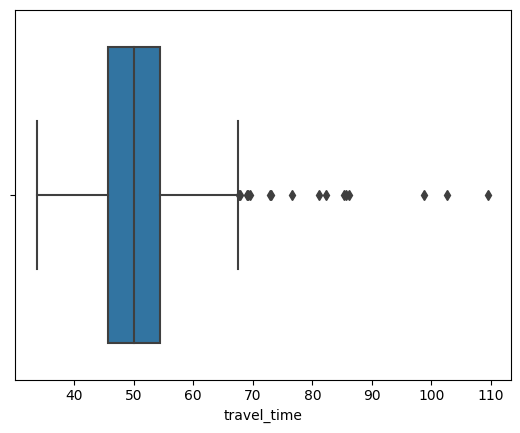

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visualize the distribution of 'travel_time' using a box plot
sns.boxplot(x=df['travel_time'])
plt.show()

In [48]:
from scipy.stats import zscore

# Calculate z-scores for 'travel_time'
z_scores = zscore(df['travel_time'])

# Find and remove outliers based on z-score (threshold = 2)
outlier_indices = (z_scores > 2) | (z_scores < -2)
df = df[~outlier_indices]

In [46]:
df.head()

,travel_time,date,start_terminal,weekday,rush_hour,hour_of_the_day,wind_speed,weather
0,52.650000,2022-09-01,Digana,1,0,8,0.1,"Rain, Overcast"
1,57.133333,2022-09-01,Kandy,1,1,10,7.9,Overcast
2,63.500000,2022-09-01,Digana,1,0,13,11.2,Overcast
3,57.283333,2022-09-01,Kandy,1,1,16,9.7,Overcast
4,53.866667,2022-09-02,Digana,1,0,8,0.3,"Rain, Partially cloudy"


In [54]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df['weather_encoded'] = label_encoder.fit_transform(df['weather'])

In [55]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

columns_to_normalize = ['hour_of_the_day', 'rush_hour', 'wind_speed']

df[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])

In [58]:
# Define features and target variable
X = df[['hour_of_the_day', 'rush_hour', 'wind_speed', 'weather_encoded', 'weekday']]
y = df['travel_time']

In [59]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [60]:
# Initialize and train the Random Forest Regressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict travel_time on the test set
predictions = model.predict(X_test)

# Calculate the mean squared error to evaluate the model
mse = mean_squared_error(y_test, predictions)
print("Mean Squared Error:", mse)

# Save the trained model for future use
joblib.dump(model, 'travel_time_prediction_model.pkl')

Mean Squared Error: 21.705500468353982


['travel_time_prediction_model.pkl']

In [61]:
from sklearn.ensemble import GradientBoostingRegressor

# Initialize and train the Gradient Boosting Regressor
model = GradientBoostingRegressor(n_estimators=50, random_state=42)
model.fit(X_train, y_train)

# Predict travel_time on the test set
predictions = model.predict(X_test)

# Calculate the mean squared error to evaluate the model
mse = mean_squared_error(y_test, predictions)
print("Mean Squared Error:", mse)

# Save the trained model for future use
joblib.dump(model, 'gradient_boosting_travel_time_model.pkl')


Mean Squared Error: 23.784535177601185


['gradient_boosting_travel_time_model.pkl']

In [62]:
import xgboost as xgb

# Set the hyperparameters grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}

# Initialize the XGBoost Regressor
xgb_model = xgb.XGBRegressor(random_state=42)

# Perform Grid Search Cross-Validation
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(X_train, y_train)

# Get the best hyperparameters and best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Print the best hyperparameters
print("Best Hyperparameters:", best_params)

# Predict travel_time on the test set using the best model
predictions = best_model.predict(X_test)

# Calculate the mean squared error to evaluate the best model
mse = mean_squared_error(y_test, predictions)
print("Mean Squared Error (Best Model):", mse)

Best Hyperparameters: {'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 300}
Mean Squared Error (Best Model): 20.569923546837693


In [64]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

features = ['hour_of_the_day', 'rush_hour', 'wind_speed', 'weather_encoded', 'weekday']
# Create the neural network model
model = Sequential()
model.add(Dense(64, input_dim=len(features), activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))  # Output layer with 1 neuron for regression

# Compile the model
model.compile(loss='mean_squared_error', optimizer=Adam(lr=0.001))

# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model
predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print("Mean Squared Error (Neural Network):", mse)


Epoch 1/100
64/64 [==============================] - 1s 6ms/step - loss: 2083.1013 - val_loss: 961.8846
Epoch 2/100
64/64 [==============================] - 0s 3ms/step - loss: 306.3607 - val_loss: 136.8235
Epoch 3/100
64/64 [==============================] - 0s 3ms/step - loss: 109.5887 - val_loss: 93.2642
Epoch 4/100
64/64 [==============================] - 0s 2ms/step - loss: 77.7875 - val_loss: 75.9133
Epoch 5/100
64/64 [==============================] - 0s 2ms/step - loss: 64.7905 - val_loss: 64.9907
Epoch 6/100
64/64 [==============================] - 0s 2ms/step - loss: 55.0691 - val_loss: 55.4629
Epoch 7/100
64/64 [==============================] - 0s 2ms/step - loss: 48.2058 - val_loss: 49.0183
Epoch 8/100
64/64 [==============================] - 0s 2ms/step - loss: 42.7218 - val_loss: 45.2688
Epoch 9/100
64/64 [==============================] - 0s 2ms/step - loss: 39.1416 - val_loss: 40.3551
Epoch 10/100
64/64 [==============================] - 0s 2ms/step - loss: 35.1370 - v